In [1]:
import networkx as nx
import random
from collections import deque, defaultdict

In [2]:

def generate_tree(N, K):
    
    T = nx.DiGraph()
    C = defaultdict(int)
    
    for i in range(N):
        T.add_node(i)
    
    for i in range(1, N):
        p = None
        while True:
            p = random.randint(0, i - 1)
            if C[p] < K:
                break
        T.add_edge(p, i)
        C[p] += 1
    
    return T


In [3]:

class DLNode:
    def __init__(self, v, nxt, prv):
        self.v = v
        self.next = nxt
        self.back = prv

class DList:
    
    MXNODES = 10000000
    nodes = [None for i in range(MXNODES)]
    cnt = 0
    
    def __init__(self, arr):
        
        self.first = None
        self.last  = None
        
        for v in arr:
            DList.nodes[DList.cnt] = DLNode(v, None, self.last)
            if self.last:
                DList.nodes[self.last].next = DList.cnt
            self.last = DList.cnt; DList.cnt += 1
            if not self.first:
                self.first = self.last
    
    def reset(self):
        DList.cnt = 0
        DList.nodes = []
    
    def append_right(self, v):
        
        DList.nodes[DList.cnt] = DLNode(v, None, self.last)
        if self.first:
            DList.nodes[self.last].next = DList.cnt
        else:
            self.first = DList.cnt
        self.last = DList.cnt; DList.cnt += 1
        
    def append_left(self, v):
        
        DList.nodes[DList.cnt] = DLNode(v, self.first, None)
        if self.first:
            DList.nodes[self.first].back = DList.cnt
        else:
            self.last = DList.cnt
        self.first = DList.cnt; DList.cnt += 1
        
    def extend_right(self, first, last):
        
        DList.nodes[self.last].next = first
        DList.nodes[first].back = self.last
        self.last = last
            
    def extend_left(self, first, last):
        
        DList.nodes[self.first].back = last
        DList.nodes[last].next = self.first
        self.first = first
        
    def remove_right(self, pos):
        
        self.last = pos
        DList.nodes[self.last].next = None
            
    def remove_left(self, pos):
        
        self.first = pos
        DList.nodes[self.first].back = None
        
    def remove_pos(self, pos):
        
        if self.first == pos:
            self.first = DList.nodes[pos].next
        if self.last == pos:
            self.last = DList.nodes[pos].back
        l = DList.nodes[pos].back; r = DList.nodes[pos].next
        if l is not None:
            DList.nodes[l].next = r
        if r is not None:
            DList.nodes[r].back = l
            
    def pop_left(self):
        
        if self.first is not None:
            self.first = DList.nodes[self.first].next
        if self.first is not None:
            DList.nodes[self.first].back = None
    
    def pop_right(self):
        
        if self.last is not None:
            self.last = DList.nodes[self.last].back
        if self.last is not None:
            DList.nodes[self.last].next = None
        

In [4]:

def get_optimal_function(T, debug=False):
    
    order = [u for u in nx.topological_sort(T)][::-1]
    S = [DList([]) for i in range(N)]
    P = [0 for i in range(N)]

    F = {e: None for e in T.edges()}

    for u in order:  ## Generamos la extensión en orden buttom-up

        if debug:
            print(f"Node {u}")

        children = [v for v in T.successors(u)]

        if debug:
            print(f"children: {children}")
        if len(children) == 0:
            continue

        if len(children) == 1:  ## En caso de un sólo hijo

            v = children[0]

            # Buscamos el menor valor libre
            i = S[v].first
            free = 1
            while i:
                if DList.nodes[i].v > free:
                    break
                free = DList.nodes[i].v + 1
                i = DList.nodes[i].next

            S[u].append_right(free)

            F[(u, v)] = free

            if i is not None:  # Sólo nos quedamos con los valores expuestos
                S[u].extend_right(i, S[v].last)
            continue

        for v in children:
            P[v] = S[v].first

        # Buscamos l2 iterando coordinadamente

        l2 = -1; active = set(children); last_erased = None
        while len(active) > 1:
            l2 += 1

            to_erase = []
            for v in active:
                while P[v] is not None and DList.nodes[P[v]].v <= l2:
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.append(v)

            for v in to_erase:
                last_erased = v
                active.remove(v)

        i1 = None  # hijo de secuencia más grande
        if len(active) == 0:
            i1 = last_erased
        else:
            i1 = next(iter(active))

        children = [i1] + [ch for ch in children if ch != i1]

        # Generamos las listas ordenadas L[1:l2 + 1]

        L = [DList(children.copy())] + [None for i in range(l2)]
        L_ = {v: [] for v in children}

        it = L[0].first
        while it is not None:
            v = DList.nodes[it].v
            L_[v].append(it)
            it = DList.nodes[it].next

        last = {v: 0 for v in children}
        M = [{v: 0 for v in children}] + [None for i in range(l2)]
        C = [len(children)] + [0 for i in range(l2)]

        for v in children:
            P[v] = S[v].first

        for i in range(1, l2 + 1):    
            to_erase = set(); has_i = set()
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                while P[v] is not None and DList.nodes[P[v]].v <= i:
                    if DList.nodes[P[v]].v == i:
                        has_i.add(v)
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.add(v)
                it = DList.nodes[it].next

            L_p = []; L_m = []
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                if v in has_i:
                    L_p.append(v)
                elif v not in to_erase:
                    L_m.append(v)
                it = DList.nodes[it].next

            C[i] = 0
            L[i] = DList(L_p + L_m)
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                L_[v].append(it)
                it = DList.nodes[it].next
                C[i] += 1

            M[i] = {v: 0 for v in children}
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                M[i][v] = last[v]
                if v in has_i:
                    last[v] = i
                it = DList.nodes[it].next

        for v in children:
            P[v] = S[v].first
            nxt = None if P[v] is None else DList.nodes[P[v]].next
            while (P[v] is not None) and (nxt is not None) and DList.nodes[nxt].v <= l2:
                P[v] = nxt
                nxt = None if P[v] is None else DList.nodes[P[v]].next

        if debug:
            print(f"l2: {l2}")

        U = deque([])

        G = {v: 0 for v in children}

        p_i1 = P[i1]
        if (p_i1 is not None) and DList.nodes[p_i1].v == l2:
            p_i1 = DList.nodes[p_i1].next

        curr = l2; lst = l2; last_i1 = l2; cnt_0 = len(children)
        active = set()
        for v in children:
            if P[v] is not None:
                active.add(v)

        while curr > 0 or cnt_0 > 0:

            cnt = 0
            for v in active:
                if DList.nodes[P[v]].v == curr:
                    cnt += 1

            if debug:
                print(f"curr: {curr}, cnt: {cnt}, cnt_0: {cnt_0}")

            if cnt == 0 and lst > curr:
                for x in range(max(curr, 1), lst):
                    U.append(x)
            lst = curr
            if cnt <= 1 and curr != 0:
                to_remove = []
                for v in active:
                    if DList.nodes[P[v]].v == curr:
                        P[v] = DList.nodes[P[v]].back
                        if P[v] is None:
                            to_remove.append(v)
                for v in to_remove:
                    active.remove(v)
                curr -= 1
                continue

            w = None
            if U:
                w = U.pop()
            else:
                while p_i1 is not None:
                    if last_i1 + 1 < DList.nodes[p_i1].v:
                        break
                    last_i1 = DList.nodes[p_i1].v
                    p_i1 = DList.nodes[p_i1].next
                w = last_i1 + 1
                last_i1 += 1

            best_j = None
            if w <= l2:      
                flag = False
                if L[w].first is not None:
                    m = M[w][DList.nodes[L[w].first].v]
                    if C[w] == C[m]:
                        best_j = DList.nodes[L[w].first].v
                    elif C[m + 1] == C[w]:
                        best_j = DList.nodes[L[m].first].v
                    else:
                        flag = True

                if L[w].first is None or flag == True:
                    for i in range(w):
                        if C[i] > C[w] and C[i + 1] == C[w]:
                            best_j = DList.nodes[L[i].first].v
            else:
                if S[i1].first is not None and DList.nodes[S[i1].first].v < w:
                    best_j = i1
                else:
                    flag = False
                    if L[l2].first is not None:
                        m = M[l2][DList.nodes[L[l2].first].v]
                        if C[l2] == C[m]:
                            best_j = DList.nodes[L[l2].first].v
                        elif C[m + 1] == C[l2]:
                            best_j = DList.nodes[L[m].first].v
                        else:
                            flag = True

                    if L[l2].first is None or flag == True:
                        for i in range(l2):
                            if C[i] > C[l2] and C[i + 1] == C[l2]:
                                best_j = DList.nodes[L[i].first].v

            if debug:
                print(f"best_j: {best_j}, w: {w}, active: {len(active)}")

            to_add = deque([])
            while P[best_j] is not None and DList.nodes[P[best_j]].v <= w:
                v_ = DList.nodes[P[best_j]].v
                if v_ > curr:
                    to_add.append(v_)
                P[best_j] = DList.nodes[P[best_j]].next
            while to_add:
                U.append(to_add.pop())

            mxx = None
            if P[best_j] is None:
                if best_j != i1:
                    for i in range(last[best_j] + 1):
                        C[i] -= 1
                else:
                    for i in range(l2 + 1):
                        C[i] -= 1
                S[best_j] = DList([])
                mxx = l2
            else:
                S[best_j].remove_left(P[best_j])
                mxx = min(l2, DList.nodes[P[best_j]].v - 1)

            ll = len(L_[best_j]); mxx = min(mxx, ll - 1)
            while mxx >= 0 and L_[best_j][mxx] != -1:
                L[mxx].remove_pos(L_[best_j][mxx])
                L_[best_j][mxx] = -1
                M[mxx][best_j] = -1
                mxx -= 1

            if G[best_j] == 0:
                cnt_0 -= 1
            G[best_j] = w
            if best_j in active:
                active.remove(best_j)

        for k, v in G.items():
            F[(u, k)] = v

        for v in children:
            S[v].append_left(G[v])

        active = set(children)
        while len(active) > 1:

            id_ = None; mn = 1e9
            for v in active:
                if DList.nodes[S[v].first].v < mn:
                    mn = DList.nodes[S[v].first].v
                    id_ = v

            S[u].append_right(mn)
            S[id_].pop_left()
            if S[id_].first is None:
                active.remove(id_)

        i1 = next(iter(active))
        S[u].extend_right(S[i1].first, S[i1].last)
        
    print("Optimal Steps:", max(F.values()))
        
    return F


In [5]:
from time import time

times = []
for N in [10, 100, 1000, 10000, 100000]:
    T = generate_tree(N, 10)
    st = time()
    F = get_optimal_function(T)
    et = time()
    print(f"Elapsed {et - st}s.\n")
    times.append(et - st)

Optimal Steps: 5
Elapsed 0.0003533363342285156s.

Optimal Steps: 12
Elapsed 0.0023925304412841797s.

Optimal Steps: 14
Elapsed 0.07076239585876465s.

Optimal Steps: 20
Elapsed 0.2355194091796875s.

Optimal Steps: 23
Elapsed 2.6006336212158203s.



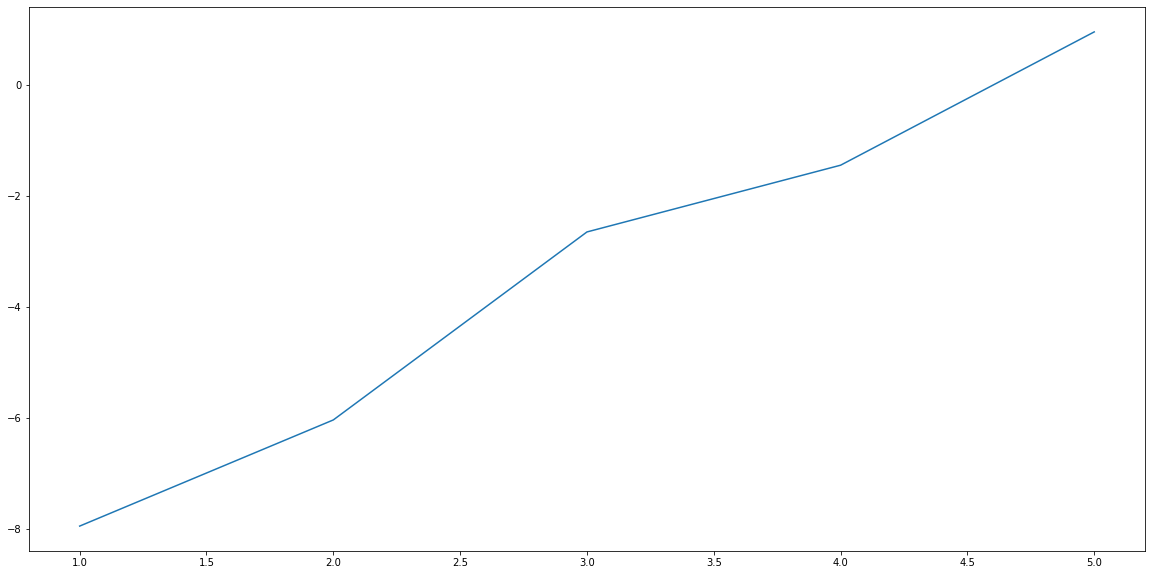

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plt.plot(range(1, 6), [np.log(t) for t in times])

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
        
###################################################################################################

        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[dest], id_[origin])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [301]:
st = time()
F = get_optimal_function(T)
et = time()

print(et - st)

Optimal Steps: 10
0.14622211456298828


In [6]:

def get_optimal_K_function(T, K, debug=False):
    
    order = [u for u in nx.topological_sort(T)][::-1]
    S = [DList([]) for i in range(N)]
    P = [0 for i in range(N)]

    F = {e: None for e in T.edges()}

    for u in order:  ## Generamos la extensión en orden buttom-up

        if debug:
            print(f"Node {u}")

        children = [v for v in T.successors(u)]

        if debug:
            print(f"children: {children}")
        if len(children) == 0:
            continue

        if len(children) == 1:  ## En caso de un sólo hijo

            v = children[0]

            # Buscamos el menor valor libre
            i = S[v].first
            free = 1
            while i:
                if DList.nodes[i].v[0] > free:
                    break
                elif DList.nodes[i].v[1] < K:
                    break
                free = DList.nodes[i].v[0] + 1
                i = DList.nodes[i].next

            if i and DList.nodes[i].v[0] == free:
                DList.nodes[i].v = (DList.nodes[i].v[0], DList.nodes[i].v[1] + 1)
                S[u].append_right(DList.nodes[i].v)
                i = DList.nodes[i].next
            else:
                S[u].append_right((free, 1))

            F[(u, v)] = free
            F[(v, u)] = free

            if i is not None:  # Sólo nos quedamos con los valores expuestos
                S[u].extend_right(i, S[v].last)
            continue

        for v in children:
            P[v] = S[v].first

        # Buscamos l2 iterando coordinadamente

        l2 = -1; active = set(children); last_erased = None
        while len(active) > 1:
            l2 += 1

            to_erase = []
            for v in active:
                while P[v] is not None and DList.nodes[P[v]].v[0] <= l2:
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.append(v)

            for v in to_erase:
                last_erased = v
                active.remove(v)

        i1 = None  # hijo de secuencia más grande
        if len(active) == 0:
            i1 = last_erased
        else:
            i1 = next(iter(active))

        children = [i1] + [ch for ch in children if ch != i1]

        # Generamos las listas ordenadas L[1:l2 + 1]

        L = [DList(children.copy())] + [None for i in range(l2)]
        L_ = {v: [] for v in children}

        it = L[0].first
        while it is not None:
            v = DList.nodes[it].v
            L_[v].append(it)
            it = DList.nodes[it].next

        last = {v: 0 for v in children}
        M = [{v: 0 for v in children}] + [None for i in range(l2)]
        C = [len(children)] + [0 for i in range(l2)]

        for v in children:
            P[v] = S[v].first
            
        for i in range(1, l2 + 1):    
            to_erase = set(); has_i = set()
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                while P[v] is not None and DList.nodes[P[v]].v[0] <= i:
                    if DList.nodes[P[v]].v[0] == i:
                        has_i.add(v)
                    P[v] = DList.nodes[P[v]].next
                if P[v] is None:
                    to_erase.add(v)
                it = DList.nodes[it].next

            L_p = []; L_m = []
            it = L[i - 1].first
            while it is not None:
                v = DList.nodes[it].v
                if v in has_i:
                    L_p.append(v)
                elif v not in to_erase:
                    L_m.append(v)
                it = DList.nodes[it].next

            C[i] = 0
            L[i] = DList(L_p + L_m)
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                L_[v].append(it)
                it = DList.nodes[it].next
                C[i] += 1

            M[i] = {v: 0 for v in children}
            it = L[i].first
            while it is not None:
                v = DList.nodes[it].v
                M[i][v] = last[v]
                if v in has_i:
                    last[v] = i
                it = DList.nodes[it].next

        for v in children:
            P[v] = S[v].first
            nxt = None if P[v] is None else DList.nodes[P[v]].next
            while (P[v] is not None) and (nxt is not None) and DList.nodes[nxt].v[0] <= l2:
                P[v] = nxt
                nxt = None if P[v] is None else DList.nodes[P[v]].next

        if debug:
            print(f"l2: {l2}")

        U = deque([])

        G = {v: 0 for v in children}

        p_i1 = P[i1]
        while (p_i1 is not None) and DList.nodes[p_i1].v[0] <= l2:
            p_i1 = DList.nodes[p_i1].next

        curr = l2; lst = l2; last_i1 = l2 + 1; last_i1_cnt = 0; cnt_0 = len(children)
        active = set()
        for v in children:
            if P[v] is not None:
                active.add(v)

        while curr > 0 or cnt_0 > 0:

            cnt = 0
            for v in active:
                if DList.nodes[P[v]].v[0] == curr:
                    cnt += DList.nodes[P[v]].v[1]

            if debug:
                print(f"curr: {curr}, cnt: {cnt}, cnt_0: {cnt_0}")

            if cnt < K and lst > curr:
                for x in range(max(curr, 1), lst):
                    if x == curr:
                        U.append((x, K - cnt))
                    else:
                        U.append((x, K))
            lst = curr
            if cnt <= K and curr != 0:
                to_remove = []
                for v in active:
                    if DList.nodes[P[v]].v[0] == curr:
                        P[v] = DList.nodes[P[v]].back
                        if P[v] is None:
                            to_remove.append(v)
                for v in to_remove:
                    active.remove(v)
                curr -= 1
                continue

            w = None
            
            if U:
                w, cc = U.pop()
                if cc > 1:
                    U.append((w, cc - 1))
            else:
                while p_i1 is not None:
                    if last_i1 == DList.nodes[p_i1].v[0] and DList.nodes[p_i1].v[1] < K:
                        w = last_i1
                        last_i1_cnt += 1
                        if last_i1_cnt + DList.nodes[p_i1].v[1] == K:
                            last_i1 += 1
                            last_i1_cnt = 0
                            p_i1 = DList.nodes[p_i1].next
                        break
                    elif last_i1 == DList.nodes[p_i1].v[0] and DList.nodes[p_i1].v[1] == K:
                        last_i1 += 1
                        last_i1_cnt = 0
                        p_i1 = DList.nodes[p_i1].next
                    elif last_i1 < DList.nodes[p_i1].v[0] and last_i1_cnt < K:
                        w = last_i1
                        last_i1_cnt += 1
                        break
                    elif last_i1 < DList.nodes[p_i1].v[0] and last_i1_cnt == K:
                        last_i1 += 1
                        last_i1_cnt = 0
                if w is None:
                    w = last_i1
                    last_i1_cnt += 1
                    if last_i1_cnt == K:
                        last_i1 += 1
                        last_i1_cnt = 0
            
            best_j = None
            if w <= l2:      
                flag = False
                if L[w].first is not None:
                    m = M[w][DList.nodes[L[w].first].v]
                    if C[w] == C[m]:
                        best_j = DList.nodes[L[w].first].v
                    elif C[m + 1] == C[w]:
                        best_j = DList.nodes[L[m].first].v
                    else:
                        flag = True

                if L[w].first is None or flag == True:
                    for i in range(w):
                        if C[i] > C[w] and C[i + 1] == C[w]:
                            best_j = DList.nodes[L[i].first].v
            else:
                if S[i1].first is not None and DList.nodes[S[i1].first].v[0] < w:
                    best_j = i1
                else:
                    flag = False
                    if L[l2].first is not None:
                        m = M[l2][DList.nodes[L[l2].first].v]
                        if C[l2] == C[m]:
                            best_j = DList.nodes[L[l2].first].v
                        elif C[m + 1] == C[l2]:
                            best_j = DList.nodes[L[m].first].v
                        else:
                            flag = True

                    if L[l2].first is None or flag == True:
                        for i in range(l2):
                            if C[i] > C[l2] and C[i + 1] == C[l2]:
                                best_j = DList.nodes[L[i].first].v

            if debug:
                print(f"best_j: {best_j}, w: {w}, active: {len(active)}")
            
            to_add = deque([])
            if P[best_j] is None:
                P[best_j] = S[best_j].first
            while P[best_j] is not None and DList.nodes[P[best_j]].v[0] < w:
                v_ = DList.nodes[P[best_j]].v
                if v_[0] > curr:
                    to_add.append(v_)
                P[best_j] = DList.nodes[P[best_j]].next
            while to_add:
                U.append(to_add.pop())

            mxx = None
            if P[best_j] is None:
                if best_j != i1:
                    for i in range(last[best_j] + 1):
                        C[i] -= 1
                else:
                    for i in range(l2 + 1):
                        C[i] -= 1
                S[best_j] = DList([])
                mxx = l2
            else:
                S[best_j].remove_left(P[best_j])
                mxx = min(l2, DList.nodes[P[best_j]].v[0] - 1)

            ll = len(L_[best_j]); mxx = min(mxx, ll - 1)
            while mxx >= 0 and L_[best_j][mxx] != -1:
                L[mxx].remove_pos(L_[best_j][mxx])
                L_[best_j][mxx] = -1
                M[mxx][best_j] = -1
                mxx -= 1

            if G[best_j] == 0:
                cnt_0 -= 1
            G[best_j] = w
            if best_j in active:
                active.remove(best_j)

        for k, v in G.items():
            F[(u, k)] = v
            F[(k, u)] = v

        for v in children:
            if S[v].first is not None and DList.nodes[S[v].first].v[0] == G[v]:
                DList.nodes[S[v].first].v = (DList.nodes[S[v].first].v[0], DList.nodes[S[v].first].v[1] + 1)
            else:
                S[v].append_left((G[v], 1))

        active = set(children)
        while len(active) > 1:

            id_ = set(); mn = 1e9; cntt = 0
            for v in active:
                if debug:
                    print(v, DList.nodes[S[v].first].v)
                if DList.nodes[S[v].first].v[0] < mn:
                    mn = DList.nodes[S[v].first].v[0]
                    cntt = DList.nodes[S[v].first].v[1]
                    id_ = set([v])
                elif DList.nodes[S[v].first].v[0] == mn:
                    cntt += DList.nodes[S[v].first].v[1]
                    id_.add(v)
                    
            if debug:
                print(mn, cntt)

            S[u].append_right((mn, cntt))
            if cntt > K:
                print("FAILED", K, cntt)
                return 0
            for v in id_:
                S[v].pop_left()
                if S[v].first is None:
                    active.remove(v)

        if active:
            i1 = next(iter(active))
            S[u].extend_right(S[i1].first, S[i1].last)
        
    print("Optimal Steps:", max(F.values()))
        
    return F


In [253]:
from time import time

times = []
for N in [10, 100, 1000, 10000, 100000]:
    T = generate_tree(N, 10)
    st = time()
    F = get_optimal_K_function(T, 5)
    et = time()
    print(f"Elapsed {et - st}s.\n")
    times.append(et - st)

Optimal Steps: 2
Elapsed 0.0028870105743408203s.

Optimal Steps: 4
Elapsed 0.056099653244018555s.

Optimal Steps: 6
Elapsed 0.03539085388183594s.

Optimal Steps: 8
Elapsed 0.33114051818847656s.

Optimal Steps: 10
Elapsed 7.778333425521851s.



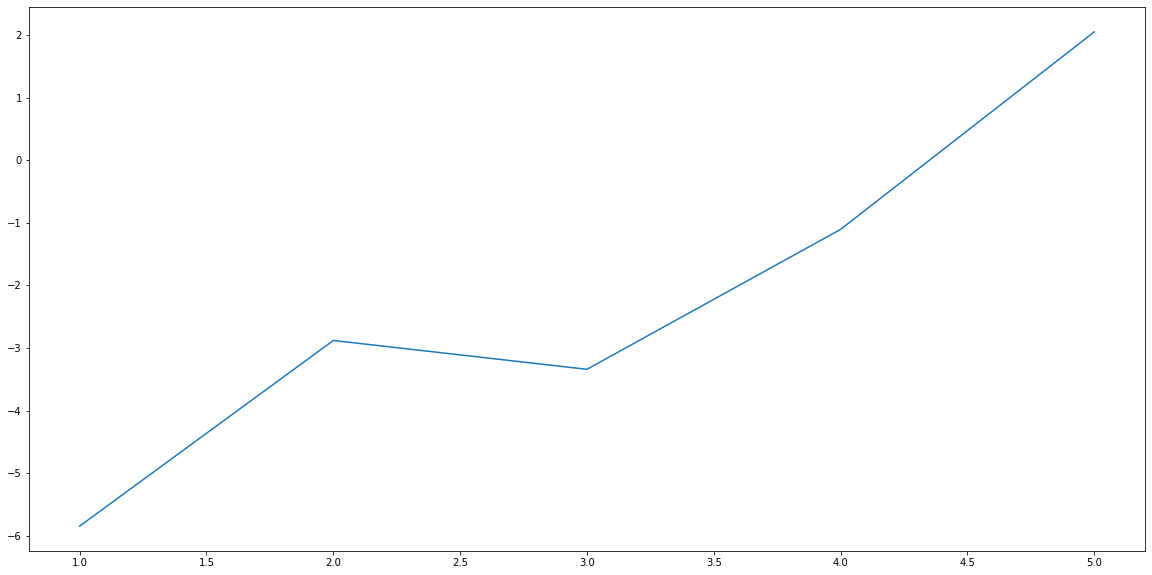

In [254]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plt.plot(range(1, 6), [np.log(t) for t in times])

In [10]:
for k in range(1, 101):
    print(f"K: {k}")
    F = get_optimal_K_function(T, k)
    check_K_function(T, 10000, F, k)

K: 1
Optimal Steps: 15
K: 2
Optimal Steps: 10
K: 3
Optimal Steps: 8
K: 4
Optimal Steps: 7
K: 5
Optimal Steps: 6
K: 6
Optimal Steps: 6
K: 7
Optimal Steps: 6
K: 8
Optimal Steps: 6
K: 9
Optimal Steps: 6
K: 10
Optimal Steps: 6
K: 11
Optimal Steps: 5
K: 12
Optimal Steps: 5
K: 13
Optimal Steps: 5
K: 14
Optimal Steps: 5
K: 15
Optimal Steps: 5
K: 16
Optimal Steps: 5
K: 17
Optimal Steps: 5
K: 18
Optimal Steps: 5
K: 19
Optimal Steps: 5
K: 20
Optimal Steps: 5
K: 21
Optimal Steps: 5
K: 22
Optimal Steps: 5
K: 23
Optimal Steps: 5
K: 24
Optimal Steps: 5
K: 25
Optimal Steps: 5
K: 26
Optimal Steps: 5
K: 27
Optimal Steps: 5
K: 28
Optimal Steps: 5
K: 29
Optimal Steps: 5
K: 30
Optimal Steps: 5
K: 31
Optimal Steps: 5
K: 32
Optimal Steps: 5
K: 33
Optimal Steps: 5
K: 34
Optimal Steps: 5
K: 35
Optimal Steps: 5
K: 36
Optimal Steps: 5
K: 37
Optimal Steps: 5
K: 38
Optimal Steps: 5
K: 39
Optimal Steps: 5
K: 40
Optimal Steps: 5
K: 41
Optimal Steps: 5
K: 42
Optimal Steps: 5
K: 43
Optimal Steps: 5
K: 44
Optimal Step

In [8]:

def check_K_function(T, N, F, K):
    
    G = T.to_undirected()
    
    E = G.edges()
    
    for e in E:
        u1, u2 = e
        val = F[(u1, u2)]
        
#         print("EDGE:", u1, u2, val)
        
        ans = 0
        V = [0] * N

        Q = deque([u1, u2]);  V[u1] = 1; V[u2] = 1
        while Q:
            u = Q.popleft()
#             print("Node", u)
            for v in G.neighbors(u):
                if not V[v]:
#                     print("edge:", u, v, F[(u, v)])
                    if F[(u, v)] == val:
                        ans += 1
                    if F[(u, v)] <= val:
                        V[v] = 1
                        Q.append(v)
        if ans + 1 > K:
            print("ERROR", ans + 1, K, val)
            return
        
        

In [ ]:
def simulate(G, N, F, s_init, nodes):
    T = []

    map_prev = {}
    
    for r in nodes:
        try:
            CV = [0 for u in range(N)]

            CV[r] = 1
            Q = deque([]); Q.append(r)
            while Q:
                u = Q.popleft()
                for v in G.predecessors(u):
                    if not CV[v]:
                        CV[v] = 1
                        Q.append(v)

            V = [0 for u in range(N)]

            R = N; s = s_init; ks = []
            for t in range(100):
                R = N - sum(V)
                P = []; k = K_func(R); ks.append(k); k_sum += k
                
                nn = 0
                for i in range(N):
                    if V[i]:
                        nn += 2**i
                
                if t == 0:
                    P, _ = get_sample_from_table(G, init_possibilities, init_next_dicts, V, k, s)
                elif nn in map_prev.keys():
                    P = map_prev[nn]
                else:
                    if N - sum(V) > 200:
                        new_possibilities, new_next_dicts = get_dp_table(G, V, k, s, 20)
                        P, _ = get_sample_from_table(G, new_possibilities, new_next_dicts, V, k, s)
                    elif N - sum(V) > 50:
                        new_possibilities, new_next_dicts = get_dp_table(G, V, k, s, 10)
                        P, _ = get_sample_from_table(G, new_possibilities, new_next_dicts, V, k, s)
                    else:
                        new_possibilities, new_next_dicts = get_dp_table(G, V, min(k, N - sum(V)), s, 1)
                        P, _ = get_sample_from_table(G, new_possibilities, new_next_dicts, V, min(k, N - sum(V)), s)
                    map_prev[nn] = P
                
                for u in P[::-1]:
                    if CV[u]:
                        I = set(get_ideal(G, V, u)[::-1])
                        V = [not (v in I) for v in range(N)]
                        s = u; break
                    else:
                        V, _ = visit(G, V, u)

                size, weight = get_size_weight(G, W, V, s)

                if size == 1:
                    T.append(t + 1)
                    print(f"Result {r}: {T[-1]}    acc: {sum(T) / (len(T))}    ks: {ks}")
                    break
                if t == 99:
                    T.append(100)
                    print(f"Result {r}: {T[-1]}    acc: {sum(T) / (len(T))}")
        except:
            print(f"{r}!!!")

    print(sum(T) / len(T), max(T), k_sum)
    
    return T
